In [42]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, classification_report, precision_score, f1_score


import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.ensemble import VotingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\viewh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\viewh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\viewh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
# Accesing News_Category_Dataset
# https://www.kaggle.com/datasets/rmisra/news-category-dataset

file_path = 'C:\\Users\\viewh\\OneDrive\\Documents\\News_Category_Dataset_v3.json'
data = []

try:
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
except FileNotFoundError:
    print(f"File not found at the path: {file_path}")
except Exception as e:
    print(f"An error occurred: {str(e)}")

df = pd.DataFrame(data)
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


Investigation Question:
What level of accuracy can we expect from an NLP model when classifying news articles into different categories? 
Is this level of accuracy sufficient to replace human classification?

In the selected dataset each news or record in consists of the following attributes:
•	category: category in which the article was published.
•	headline: the headline of the news article.
•	authors: list of authors who contributed to the article.
•	link: link to the original news article.
•	short_description: Abstract of the news article.
•	date: publication date of the article.
The selected metric is accuracy as the higher the accuracy the process can accept low percent of wrongly classified records

Exploratory Analysis

In [44]:
# dataset information
# null values are not observed 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209527 non-null  object
 2   category           209527 non-null  object
 3   short_description  209527 non-null  object
 4   authors            209527 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB


In [45]:
#Assess the length of the headline feature
df['char_count']= df.headline.apply(len)
print('mean_count:', df['char_count'].mean())
print('min_count:', df['char_count'].min())
print('max_count:', df['char_count'].max()) 

mean_count: 58.415354584373375
min_count: 0
max_count: 320


In [46]:
#remove records without characters 
df = df[df['char_count'] != 0]

In [47]:
#Confirming no records without letter
df['char_count']= df.headline.apply(len)
print('mean_count:', df['char_count'].mean())
print('min_count:', df['char_count'].min())
print('max_count:', df['char_count'].max())

mean_count: 58.41702741014027
min_count: 2
max_count: 320


(0.0, 200.0)

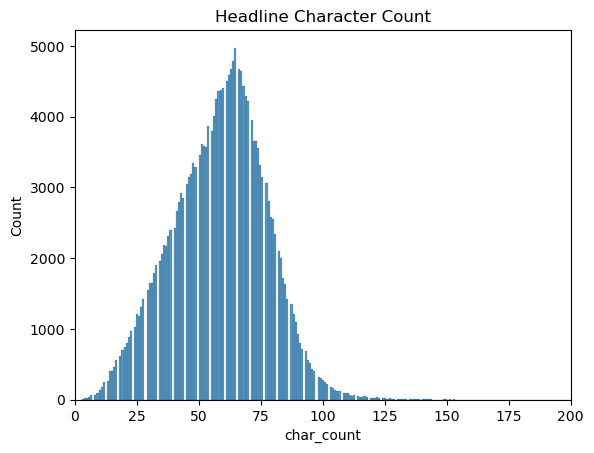

In [49]:
# heaadline character count distribution 
ig, ax = plt.subplots()
sns.histplot(df['char_count'], ax = ax).set_title('Headline Character Count')
ax.set_xlim(0, 200)
#records character count uniformly distributed

In [54]:
# confirm no null values in feature or category
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
char_count           0
dtype: int64

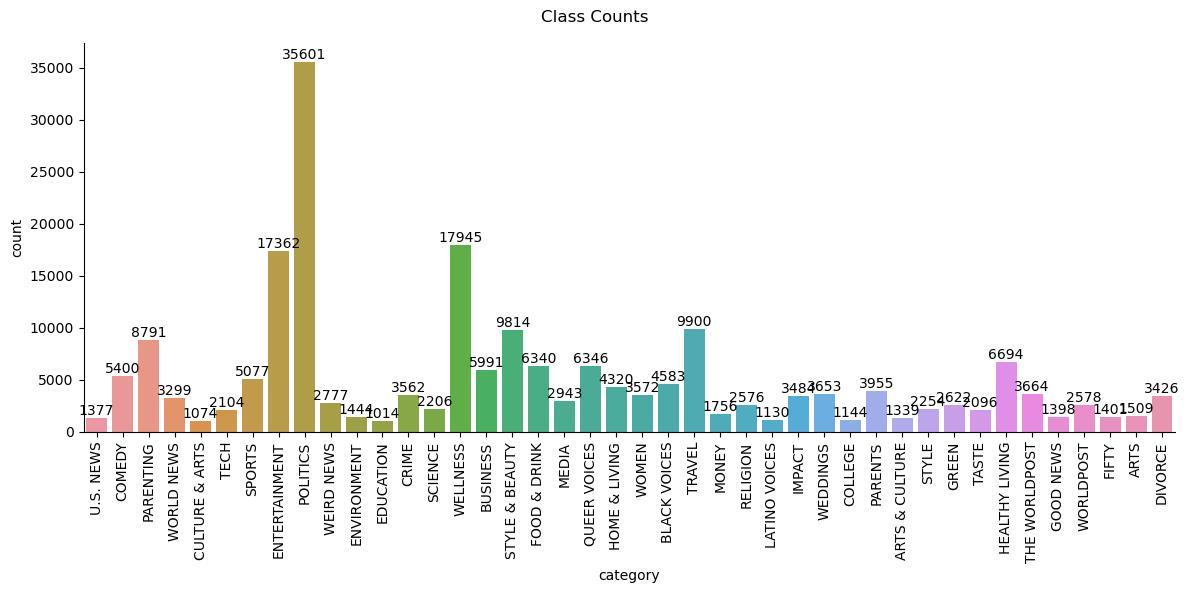

In [50]:
#Class distribution (categories)
# Create a catplot
fig = sns.catplot(x='category', kind='count', data=df, height=6, aspect=2)  

fig.fig.suptitle("Class Counts")
fig.set_xticklabels(rotation=90)

for ax in fig.axes.flat:
    ax.bar_label(ax.containers[0], fontsize=10)  

plt.tight_layout()

plt.show()

Data Setup

In [51]:
# Evaluate how many different classes(categories)
df.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [52]:
# count the number of categories
category_count = df['category'].nunique()
category_count

42

In [53]:
# Reduce classes to 16 for computational simplification
# Combine some categories based on similitud and remove others.
df['category'] = df['category'].replace('COLLEGE', 'EDUCATION')
df['category'] = df['category'].replace('ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].replace('CULTURE & ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].replace('WELLNESS', 'HEALTHY LIVING')
df['category'] = df['category'].replace('PARENTS', 'PARENTING')
df['category'] = df['category'].replace('STYLE', 'STYLE & BEAUTY')
df['category'] = df['category'].replace('GREEN', 'ENVIRONMENT')
values_to_remove = ['WEIRD NEWS', 'FOOD & DRINK', 'U.S. NEWS', 'WORLD NEWS',  'MONEY', 'QUEER VOICES', 'BLACK VOICES', 'TECH', 'MEDIA', 'LATINO VOICES', 'COMEDY', 'IMPACT', 'TASTE', 'GOOD NEWS', 'THE WORLDPOST', 'WORLDPOST', 'WEDDINGS', 'DIVORCE', 'FIFTY']
df = df[~df['category'].isin(values_to_remove)]
df = df.reset_index(drop=True)

In [55]:
#Confirm 16 categories
category_count = df['category'].nunique()
category_count

16

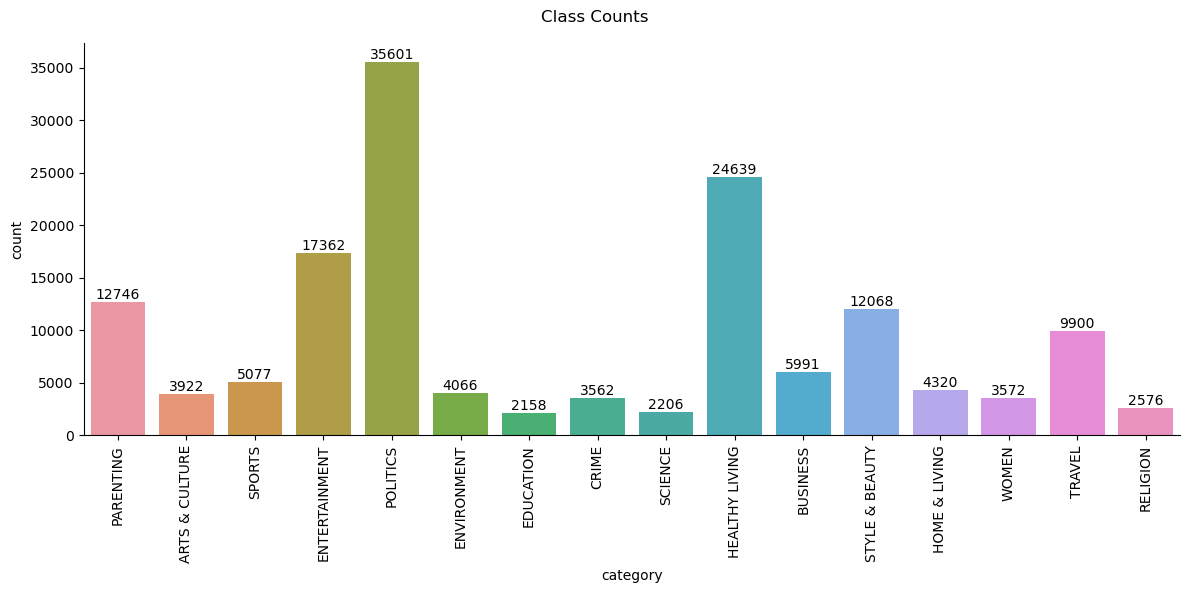

In [56]:
# Classes Distribution for analysis
fig = sns.catplot(x='category', kind='count', data=df, height=6, aspect=2) 

fig.fig.suptitle("Class Counts")
fig.set_xticklabels(rotation=90)

for ax in fig.axes.flat:
    ax.bar_label(ax.containers[0], fontsize=10)


plt.tight_layout()

plt.show()

In [57]:
# Combine Headline and Short_description column to enhance the available data for train and predict
df['alltext'] = df['headline'] + ' ' + df['short_description']
df

,link,headline,category,short_description,authors,date,char_count,alltext
0,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,56,The Funniest Tweets From Parents This Week (Se...
1,https://www.huffpost.com/entry/mija-documentar...,How A New Documentary Captures The Complexity ...,ARTS & CULTURE,"In ""Mija,"" director Isabel Castro combined mus...",Marina Fang,2022-09-22,76,How A New Documentary Captures The Complexity ...
2,https://www.huffpost.com/entry/hulu-reboot-sho...,'Reboot' Is A Clever And Not Too Navel-Gazey L...,ARTS & CULTURE,"Starring Keegan-Michael Key, Judy Greer and Jo...",Marina Fang and Candice Frederick,2022-09-20,67,'Reboot' Is A Clever And Not Too Navel-Gazey L...
3,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20,60,"Maury Wills, Base-Stealing Shortstop For Dodge..."
4,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",,2022-09-20,60,Golden Globes Returning To NBC In January Afte...
...,...,...,...,...,...,...,...,...
149761,https://www.huffingtonpost.com/entry/allard-va...,Allard Van Hoorn's 'Urban Songline' Explores R...,ARTS & CULTURE,A recent exhibition at Storefront for Art and ...,,2012-01-28,108,Allard Van Hoorn's 'Urban Songline' Explores R...
149762,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28,69,Maria Sharapova Stunned By Victoria Azarenka I...
149763,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28,99,"Giants Over Patriots, Jets Over Colts Among M..."
149764,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28,53,Aldon Smith Arrested: 49ers Linebacker Busted ...


Text Preprocessing
Tokenize headline, remove stop words, punctuation and capitalization

Initialize X and y, Conduct Text Preprocessing which involves tokenizing the headlines, eliminating stop words, punctuation, and capitalization, applying lemmatization, utilizing LabelEncoder, and employing vectorization techniques on the dataset.

In [58]:

# Assign 'alltext' as the input feature and 'category' as the target
X = df['alltext']
y = df['category']

# Split with the data for training and testing 
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices = []
test_indices = []

# Split the data while maintaining class distribution
for train_index, test_index in sss.split(X, y):
    train_indices.append(train_index)
    test_indices.append(test_index)

# Indices to create the training and testing sets
X_train = X[train_indices[0]]
X_test = X[test_indices[0]]
y_train = y[train_indices[0]]
y_test = y[test_indices[0]]

# Tokenization and Text Normalization
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Apply Tokenization to each row in X_train and store in X_train_preprocessed
num_samples = X_train.shape[0]
X_train_preprocessed = []

for i in range(num_samples):
    row = X_train.iloc[i]
    preprocessed_text = preprocess_text(row)
    X_train_preprocessed.append(preprocessed_text)

# Apply Tokenization to each row in X_test and store in X_test_preprocessed
num_samples = X_test.shape[0]
X_test_preprocessed = []

for i in range(num_samples):
    row = X_test.iloc[i]
    preprocessed_text = preprocess_text(row)
    X_test_preprocessed.append(preprocessed_text)

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Vectorize the preprocessed text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english') 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_preprocessed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_preprocessed)


In [59]:
#MULTINOMIAL 

# Define a grid of hyperparameters for MultinomialNB
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 10.0, 100.0], 
}
clf = MultinomialNB()

# GridSearchCV cross-validation and scoring 
grid_search_nb = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', refit=True)

nbstart = time.time()
grid_search_nb.fit(X_train_tfidf, y_train_encoded)
nbstop = time.time()

# Get the best model and its hyperparameters
best_clf = grid_search_nb.best_estimator_
nb_best_alpha = best_clf.alpha

# Predict categories for the training set
y_train_pred = best_clf.predict(X_train_tfidf)

# Predict categories for the test set
y_test_pred = best_clf.predict(X_test_tfidf)

# Train set results
nb_precision_train = precision_score(y_train_encoded, y_train_pred, average='weighted')
nb_recall_train = recall_score(y_train_encoded, y_train_pred, average='weighted')
nb_f1_train = f1_score(y_train_encoded, y_train_pred, average='weighted')
nb_train_accuracy = accuracy_score(y_train_encoded, y_train_pred)

# Test set results
nb_precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted')
nb_recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted')
nb_f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')
nb_test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

class_names = label_encoder.classes_
nb_time = nbstop - nbstart

# Results
results_data = {
    'Metric': ['Best Alpha', 'Train Precision', 'Train Recall', 'Train F1-Score', 'Train Accuracy',
               'Test Precision', 'Test Recall', 'Test F1-Score', 'Test Accuracy', 'Grid Search Time'],
    'NB Results': [nb_best_alpha, nb_precision_train, nb_recall_train, nb_f1_train, nb_train_accuracy,
              nb_precision_test, nb_recall_test, nb_f1_test, nb_test_accuracy, nb_time]
}

results_df = pd.DataFrame(results_data)


# Calculate classification report metrics for train and test data
train_classification_report = classification_report(y_train_encoded, y_train_pred, target_names=class_names, output_dict=True)
test_classification_report = classification_report(y_test_encoded, y_test_pred, target_names=class_names, output_dict=True)

train_classification_df = pd.DataFrame(train_classification_report).transpose()
test_classification_df = pd.DataFrame(test_classification_report).transpose()

train_classification_df.rename(columns={'precision': 'Train Precision', 'recall': 'Train Recall', 'f1-score': 'Train F1-Score', 'support': 'Train Support'}, inplace=True)
test_classification_df.rename(columns={'precision': 'Test Precision', 'recall': 'Test Recall', 'f1-score': 'Test F1-Score', 'support': 'Test Support'}, inplace=True)

# Print Results

print("\nBest alpha:", nb_best_alpha)

print(results_df)

print("Classification Report by Category (Train Data) for the Best Hyperparameter:")
print(train_classification_df)

print("\nClassification Report by Category (Test Data) for the Best Hyperparameter:")
print(test_classification_df)



Best alpha: 0.1
             Metric  NB Results
0        Best Alpha    0.100000
1   Train Precision    0.842465
2      Train Recall    0.828248
3    Train F1-Score    0.819168
4    Train Accuracy    0.828248
5    Test Precision    0.730918
6       Test Recall    0.714996
7     Test F1-Score    0.689356
8     Test Accuracy    0.714996
9  Grid Search Time    3.216669
Classification Report by Category (Train Data) for the Best Hyperparameter:
                Train Precision  Train Recall  Train F1-Score  Train Support
ARTS & CULTURE         0.963312      0.619382        0.753977    3137.000000
BUSINESS               0.900579      0.551846        0.684347    4793.000000
CRIME                  0.898283      0.715789        0.796719    2850.000000
EDUCATION              0.941176      0.324450        0.482551    1726.000000
ENTERTAINMENT          0.825894      0.883217        0.853594   13889.000000
ENVIRONMENT            0.889912      0.623732        0.733418    3253.000000
HEALTHY LIVING  

In [60]:
#Logistic_Regression

# Define a grid of hyperparameters for Logistic Regression
param_grid = {'penalty': ['l1', 'l2', 'none'],
              'fit_intercept': [True, False]}

clf = LogisticRegression()

# GridSearchCV cross-validation and scoring
grid_search_lr = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', refit=True)

lrstart = time.time()
grid_search_lr.fit(X_train_tfidf, y_train_encoded)
lrstop = time.time()

# Get the best model and its hyperparameters
lr_best_clf = grid_search_lr.best_estimator_

# Predict categories for the training set
y_train_pred = lr_best_clf.predict(X_train_tfidf)

# Predict categories for the test set
y_test_pred = lr_best_clf.predict(X_test_tfidf)

# Train set metrics results
lr_precision_train = precision_score(y_train_encoded, y_train_pred, average='weighted')
lr_recall_train = recall_score(y_train_encoded, y_train_pred, average='weighted')
lr_f1_train = f1_score(y_train_encoded, y_train_pred, average='weighted')
lr_train_accuracy = accuracy_score(y_train_encoded, y_train_pred)

# Test set metrics results
lr_precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted')
lr_recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted')
lr_f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')
lr_test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

# Print metrics by category 
lr_time = lrstop - lrstart
lr_best_para = grid_search_lr.best_params_


# Results
results_data = {
    'Metric': ['Best Parameters', 'Train Precision', 'Train Recall', 'Train F1-Score', 'Train Accuracy',
               'Test Precision', 'Test Recall', 'Test F1-Score', 'Test Accuracy', 'Grid Search Time'],
    'lr Results': [lr_best_para, lr_precision_train, lr_recall_train, lr_f1_train, lr_train_accuracy,
              lr_precision_test, lr_recall_test, lr_f1_test, lr_test_accuracy, lr_time]
}

results_df = pd.DataFrame(results_data)

# Calculate classification report metrics for train and test data
class_names = label_encoder.classes_
train_classification_report = classification_report(y_train_encoded, y_train_pred, target_names=class_names, output_dict=True)
test_classification_report = classification_report(y_test_encoded, y_test_pred, target_names=class_names, output_dict=True)

train_classification_df = pd.DataFrame(train_classification_report).transpose()
test_classification_df = pd.DataFrame(test_classification_report).transpose()

train_classification_df.rename(columns={'precision': 'Train Precision', 'recall': 'Train Recall', 'f1-score': 'Train F1-Score', 'support': 'Train Support'}, inplace=True)
test_classification_df.rename(columns={'precision': 'Test Precision', 'recall': 'Test Recall', 'f1-score': 'Test F1-Score', 'support': 'Test Support'}, inplace=True)

# Print Results

print("\nBest parameter:", lr_best_para)

print(results_df)

print("Classification Report by Category (Train Data) for the Best Hyperparameter:")
print(train_classification_df)

print("\nClassification Report by Category (Test Data) for the Best Hyperparameter:")
print(test_classification_df)


Best parameter: {'fit_intercept': False, 'penalty': 'l2'}
             Metric                                 lr Results
0   Best Parameters  {'fit_intercept': False, 'penalty': 'l2'}
1   Train Precision                                   0.832041
2      Train Recall                                    0.83318
3    Train F1-Score                                    0.82909
4    Train Accuracy                                    0.83318
5    Test Precision                                   0.756527
6       Test Recall                                   0.760967
7     Test F1-Score                                   0.753575
8     Test Accuracy                                   0.760967
9  Grid Search Time                                 422.799895
Classification Report by Category (Train Data) for the Best Hyperparameter:
                Train Precision  Train Recall  Train F1-Score  Train Support
ARTS & CULTURE         0.831951      0.607587        0.702284     3137.00000
BUSINESS          

In [62]:
# Ensemble Classifiers
lr_clf = LogisticRegression(fit_intercept=False, penalty='l2')
nb_clf = MultinomialNB(alpha=0.1)  

# Create the ensemble using VotingClassifier
ensemble_clf = VotingClassifier(estimators=[
    ('multinomial_nb', nb_clf),
    ('logistic_lr', lr_clf),
], voting='hard')  

enstart = time.time()
ensemble_clf.fit(X_train_tfidf, y_train_encoded)
enstop = time.time()

# Predict categories for the training set
y_train_pred = ensemble_clf.predict(X_train_tfidf)

# Predict categories for the test set
y_test_pred = ensemble_clf.predict(X_test_tfidf)

# Train set metrics results
en_precision_train = precision_score(y_train_encoded, y_train_pred, average='weighted')
en_recall_train = recall_score(y_train_encoded, y_train_pred, average='weighted')
en_f1_train = f1_score(y_train_encoded, y_train_pred, average='weighted')
en_train_accuracy = accuracy_score(y_train_encoded, y_train_pred)

# Test set metrics results
en_precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted')
en_recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted')
en_f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')
en_test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

# Print metrics by category within y_test
class_names = label_encoder.classes_
en_time = enstop - enstart
en_best_para = 'N/A'


# Results
results_data = {
    'Metric': ['Best Parameters', 'Train Precision', 'Train Recall', 'Train F1-Score', 'Train Accuracy',
               'Test Precision', 'Test Recall', 'Test F1-Score', 'Test Accuracy', 'Grid Search Time'],
    'En Results': [en_best_para, en_precision_train, en_recall_train, en_f1_train, en_train_accuracy,
              en_precision_test, en_recall_test, en_f1_test, en_test_accuracy, en_time]
}

results_df = pd.DataFrame(results_data)


# Calculate classification report metrics for train and test data
train_classification_report = classification_report(y_train_encoded, y_train_pred, target_names=class_names, output_dict=True)
test_classification_report = classification_report(y_test_encoded, y_test_pred, target_names=class_names, output_dict=True)

train_classification_df = pd.DataFrame(train_classification_report).transpose()
test_classification_df = pd.DataFrame(test_classification_report).transpose()

train_classification_df.rename(columns={'precision': 'Train Precision', 'recall': 'Train Recall', 'f1-score': 'Train F1-Score', 'support': 'Train Support'}, inplace=True)
test_classification_df.rename(columns={'precision': 'Test Precision', 'recall': 'Test Recall', 'f1-score': 'Test F1-Score', 'support': 'Test Support'}, inplace=True)

# Print Results

print(results_df)

print("Classification Report by Category (Train Data) for the Best Hyperparameter:")
print(train_classification_df)

print("\nClassification Report by Category (Test Data) for the Best Hyperparameter:")
print(test_classification_df)

             Metric En Results
0   Best Parameters        N/A
1   Train Precision   0.841038
2      Train Recall   0.831186
3    Train F1-Score   0.824138
4    Train Accuracy   0.831186
5    Test Precision   0.751234
6       Test Recall   0.738299
7     Test F1-Score    0.72403
8     Test Accuracy   0.738299
9  Grid Search Time  11.347623
Classification Report by Category (Train Data) for the Best Hyperparameter:
                Train Precision  Train Recall  Train F1-Score  Train Support
ARTS & CULTURE         0.850757      0.734141        0.788159    3137.000000
BUSINESS               0.795704      0.711037        0.750992    4793.000000
CRIME                  0.832227      0.791930        0.811579    2850.000000
EDUCATION              0.752817      0.580533        0.655545    1726.000000
ENTERTAINMENT          0.792603      0.908849        0.846755   13889.000000
ENVIRONMENT            0.797883      0.741469        0.768642    3253.000000
HEALTHY LIVING         0.744853      0.93602

In [65]:
# Performance Summary
results_data_all= {
    'Metric': ['Best Alpha', 'Train Precision', 'Train Recall', 'Train F1-Score', 'Train Accuracy',
               'Test Precision', 'Test Recall', 'Test F1-Score', 'Test Accuracy', 'Grid Search Time'],
    'NB Results': [nb_best_alpha, nb_precision_train, nb_recall_train, nb_f1_train, nb_train_accuracy,
              nb_precision_test, nb_recall_test, nb_f1_test, nb_test_accuracy, nb_time],
    'lr Results': [lr_best_para, lr_precision_train, lr_recall_train, lr_f1_train, lr_train_accuracy,
              lr_precision_test, lr_recall_test, lr_f1_test, lr_test_accuracy, lr_time],
    'En Results': [en_best_para, en_precision_train, en_recall_train, en_f1_train, en_train_accuracy,
              en_precision_test, en_recall_test, en_f1_test, en_test_accuracy, en_time]
}

results_df_all = pd.DataFrame(results_data_all)
print(results_df_all)

             Metric  NB Results                                 lr Results  \
0        Best Alpha    0.100000  {'fit_intercept': False, 'penalty': 'l2'}   
1   Train Precision    0.842465                                   0.832041   
2      Train Recall    0.828248                                    0.83318   
3    Train F1-Score    0.819168                                    0.82909   
4    Train Accuracy    0.828248                                    0.83318   
5    Test Precision    0.730918                                   0.756527   
6       Test Recall    0.714996                                   0.760967   
7     Test F1-Score    0.689356                                   0.753575   
8     Test Accuracy    0.714996                                   0.760967   
9  Grid Search Time    3.216669                                 422.799895   

  En Results  
0        N/A  
1   0.841038  
2   0.831186  
3   0.824138  
4   0.831186  
5   0.751234  
6   0.738299  
7    0.72403  
8   0.

Conclusion:

The study commenced by utilizing the headline as the primary input feature and assessed several models, including Random Forest, Decision Tree, and Neural Network. Unfortunately, the inclusion of the SVC model was impractical due to its extensive runtime, exceeding 15 hours. Notably, both the Random Forest and Decision Tree models displayed symptoms of overfitting, characterized by high training accuracy but test accuracy consistently below 60%.

Efforts were made to enhance performance by introducing the "short_description" feature as an input. However, this endeavor did not yield improved results compared to using only the headline as input. Subsequently, the study proceeded to create a novel feature by amalgamating the text from both the headline and short_description, consolidating them into a single column labeled "all text." This novel feature became the focal point for the final modeling phase.

Among the diverse modeling approaches explored, logistic regression emerged as the top-performing model for this dataset, achieving an accuracy rate of 0.76. It consistently demonstrated robust performance in terms of accuracy, precision, and recall, all while maintaining an acceptable runtime.

Resource limitations constrained further exploration of new models. Therefore, the subsequent step in this study involves an investigation into the SVC model, initially omitted due to its prolonged execution time.

Moving forward, the applicability of this technique to real-world scenarios appears promising, given that the dataset size is significantly smaller than the 200k records available for this exercise. It is essential to note that an accuracy rate of 0.76, while seemingly modest for replacing human judgment in record classification, represents a noteworthy improvement. This is particularly significant when considering that the initial models began with accuracy rates below 60%. Moreover, upon reviewing records where the model failed during testing, it became apparent that the model's predictions were often more accurate than human judgments, underscoring the inconsistency in human assessment.


Interpreting Results

In [76]:
# Below of a look of the features after the tranformation process
data = {
    'X_train': X_train[:10].values,
    'X_train_preprocessed': X_train_preprocessed[:10]
}

df = pd.DataFrame(data)
display(df)

,X_train,X_train_preprocessed
0,How to Stay Guilt-Free This Holiday Season Thi...,stay holiday season year remind lot child ever...
1,Starwood And Airbnb Are Poised To Take Cuba's ...,starwood airbnb poised take cuba hospitality i...
2,6 Fabulous Apres-Ski Hotel Spas (PHOTOS) What'...,6 fabulous hotel spa photo better crawling sof...
3,"Woman Speaks Out About Street Harassment, Gets...",woman speaks street harassment get harassed on...
4,Nurse Charged In Death Of Ex-Trump Adviser H.R...,nurse charged death adviser mcmaster father ch...
5,Maxwell Brings Viral Cashier On Stage To Sing ...,maxwell brings viral cashier stage sing nail word
6,One Humanitarian's Simple And Profound Answer ...,one humanitarian simple profound answer trump ...
7,Woman Who Accused Bill Clinton Of Sexual Assau...,woman accused bill clinton sexual assault join...
8,Jennifer Love Hewitt Wants A 'Can't Hardly Wai...,jennifer love hewitt want hardly wait reunion ...
9,Watch Emma Stone React To Andrew Garfield And ...,watch emma stone react andrew garfield ryan re...


In [66]:
# Best Model Logistic Regression
LogisticRegression(fit_intercept=False, penalty='l2')
logistic_regression_model = LogisticRegression(fit_intercept=False, penalty='l2')

logistic_regression_model.fit(X_train_tfidf, y_train_encoded)
y_pred = logistic_regression_model.predict(X_test_tfidf)

# Get the best model and its hyperparameters

# Predict categories for the training set
y_train_pred = lr_best_clf.predict(X_train_tfidf)

# Predict categories for the test set
y_test_pred = lr_best_clf.predict(X_test_tfidf)

# Test set metrics results
lr_precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted')
lr_recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted')
lr_f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')
lr_test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

# Results
results_lr = {
    'Metric': ['Test Precision', 'Test Recall', 'Test F1-Score', 'Test Accuracy'],
    'lr Results': [lr_precision_test, lr_recall_test, lr_f1_test, lr_test_accuracy]
}

Summary_Results_df = pd.DataFrame(results_lr)

# Calculate classification report metrics

class_names = label_encoder.classes_
test_classification_report = classification_report(y_test_encoded, y_test_pred, target_names=class_names, output_dict=True)
test_classification_df = pd.DataFrame(test_classification_report).transpose()
test_classification_df.rename(columns={'precision': 'Test Precision', 'recall': 'Test Recall', 'f1-score': 'Test F1-Score', 'support': 'Test Support'}, inplace=True)

# Print Results

print(Summary_Results_df)

print("\nClassification Report by Category (Test Data) for the Best Hyperparameter:")
print(test_classification_df)

print("Accuracy: {:0.5f}".format(accuracy_score(y_test_encoded, y_pred)))

           Metric  lr Results
0  Test Precision    0.756527
1     Test Recall    0.760967
2   Test F1-Score    0.753575
3   Test Accuracy    0.760967

Classification Report by Category (Test Data) for the Best Hyperparameter:
                Test Precision  Test Recall  Test F1-Score  Test Support
ARTS & CULTURE        0.682310     0.481529       0.564600    785.000000
BUSINESS              0.680988     0.529215       0.595585   1198.000000
CRIME                 0.723776     0.581461       0.644860    712.000000
EDUCATION             0.610000     0.423611       0.500000    432.000000
ENTERTAINMENT         0.745479     0.783473       0.764004   3473.000000
ENVIRONMENT           0.678400     0.521525       0.589708    813.000000
HEALTHY LIVING        0.727069     0.855722       0.786167   4928.000000
HOME & LIVING         0.805812     0.706019       0.752622    864.000000
PARENTING             0.728748     0.739898       0.734281   2549.000000
POLITICS              0.812556     0.898034 

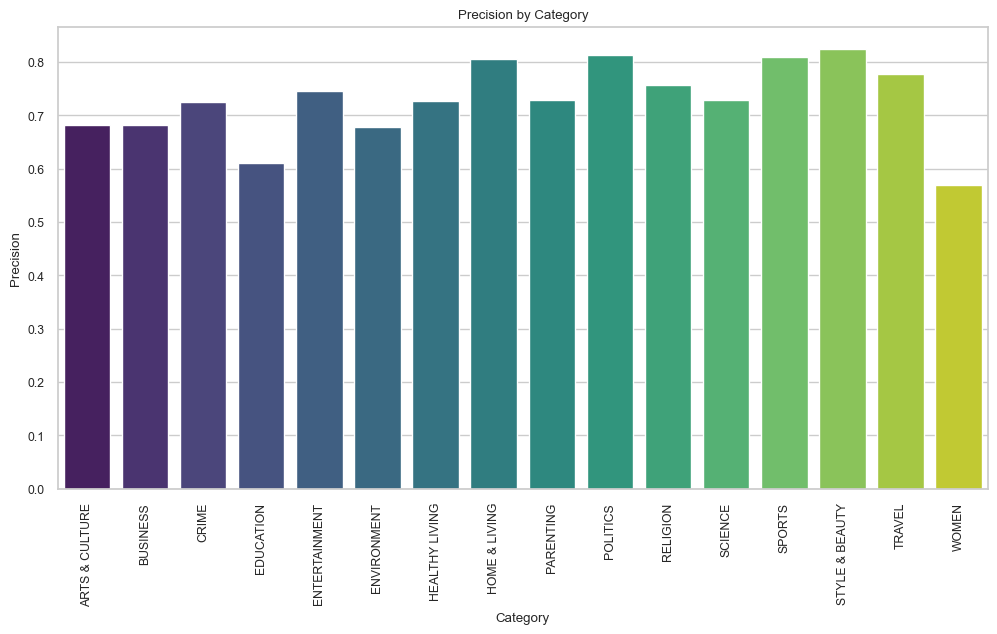

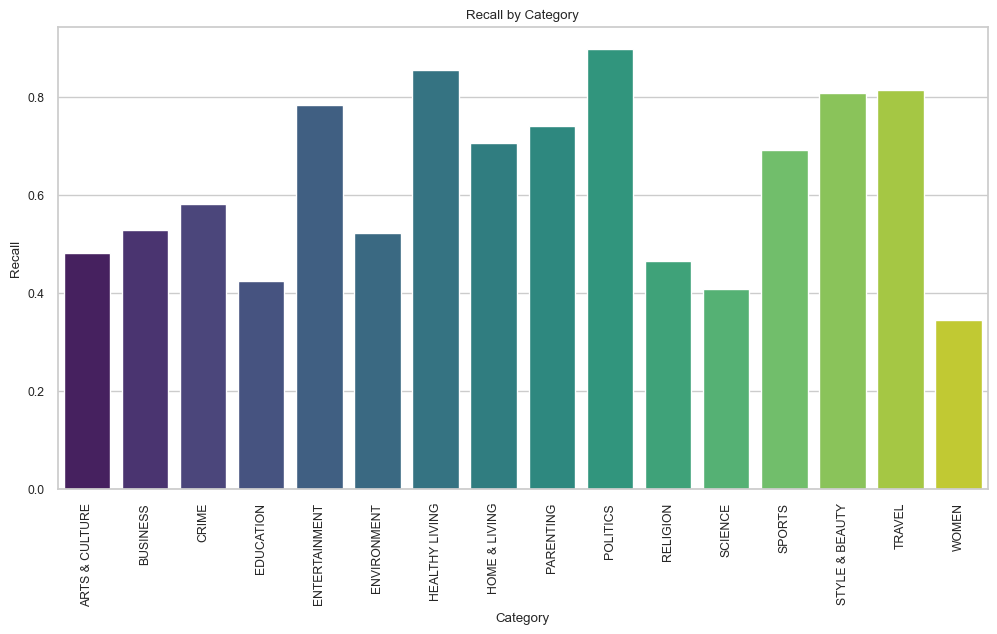

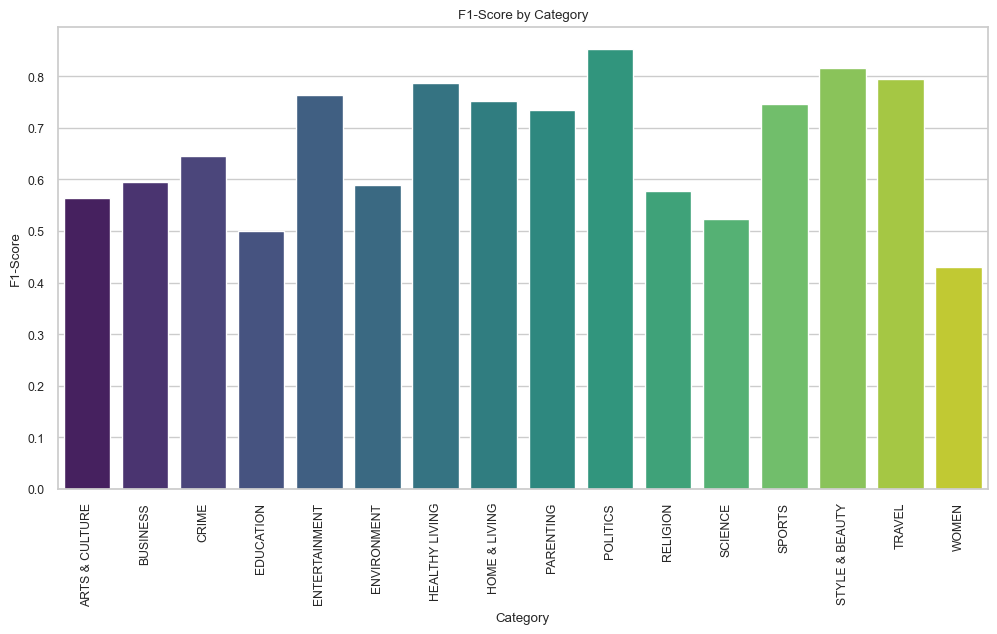

In [78]:
#visualization of the metrics results by category
# Extract precision, recall, and F1-score by category
precision_by_category = [test_classification_report[label]['precision'] for label in class_names]
recall_by_category = [test_classification_report[label]['recall'] for label in class_names]
f1_score_by_category = [test_classification_report[label]['f1-score'] for label in class_names]

# Create a bar chart for precision by category
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=precision_by_category, palette='viridis')
plt.title('Precision by Category')
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Precision')
plt.show()

# Create a bar chart for recall by category
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=recall_by_category, palette='viridis')
plt.title('Recall by Category')
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Recall')
plt.show()

# Create a bar chart for F1-score by category
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=f1_score_by_category, palette='viridis')
plt.title('F1-Score by Category')
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('F1-Score')
plt.show()

The performance of predictions for the "Woman and Education" class consistently lags behind that of the other classes, whereas predictions for "Home & Living," "Politics," "Sport and Style," and "Beauty" consistently achieve accuracy levels above 80%.

In [74]:
# sample of prediction results , below the 1st ten testing news 
class_names = label_encoder.classes_
y_pred0 = logistic_regression_model.predict(X_test_tfidf[1:11])
actual_class0 = y_test_encoded[1:11]
actual_class_names = [class_names[i] for i in actual_class0]

results_df = pd.DataFrame({
    'Predicted Class Name': [class_names[i] for i in y_pred0],
    'Actual Class Name': actual_class_names,
   })
display(results_df)


,Predicted Class Name,Actual Class Name
0,POLITICS,POLITICS
1,ENVIRONMENT,ENVIRONMENT
2,BUSINESS,HEALTHY LIVING
3,PARENTING,PARENTING
4,STYLE & BEAUTY,STYLE & BEAUTY
5,HEALTHY LIVING,HEALTHY LIVING
6,ENVIRONMENT,ENVIRONMENT
7,POLITICS,POLITICS
8,HOME & LIVING,TRAVEL
9,HEALTHY LIVING,HEALTHY LIVING


This example demonstrates the model's impressive performance, achieving an 80% accuracy rate. Upon examining the misclassified instances, it becomes evident that the model's predictions are often more accurate than the predefined categories in the dataset.

After examining the logistic model's ability to accurately categorize news posts into various categories, we will now proceed to highlight the words that significantly contribute to these results. 

In [69]:
# Below the list of feature words representing the top 3 feature per category

feature_names = tfidf_vectorizer.get_feature_names_out()
top_weights_df = pd.DataFrame(columns=['Category', 'Feature', 'Weight'])

for i, category in enumerate(class_names):
    coef = logistic_regression_model.coef_[i]
    top_indices = coef.argsort()[-3:][::-1] 
    top_features = [feature_names[idx] for idx in top_indices]
    top_weights = coef[top_indices]
    
    category_weights_df = pd.DataFrame({
        'Category': [category] * 3,  
        'Feature': top_features,
        'Weight': top_weights
    })
    top_weights_df = pd.concat([top_weights_df, category_weights_df])

display(top_weights_df)

,Category,Feature,Weight
0,ARTS & CULTURE,artist,9.862783
1,ARTS & CULTURE,art,9.303047
2,ARTS & CULTURE,imageblog,6.906652
0,BUSINESS,business,8.198967
1,BUSINESS,company,6.328369
2,BUSINESS,krugman,5.519141
0,CRIME,police,6.928683
1,CRIME,cop,6.610853
2,CRIME,allegedly,5.982580
0,EDUCATION,education,7.713273


The top three words are closely aligned with the assigned category, indicating the model's excellent performance.

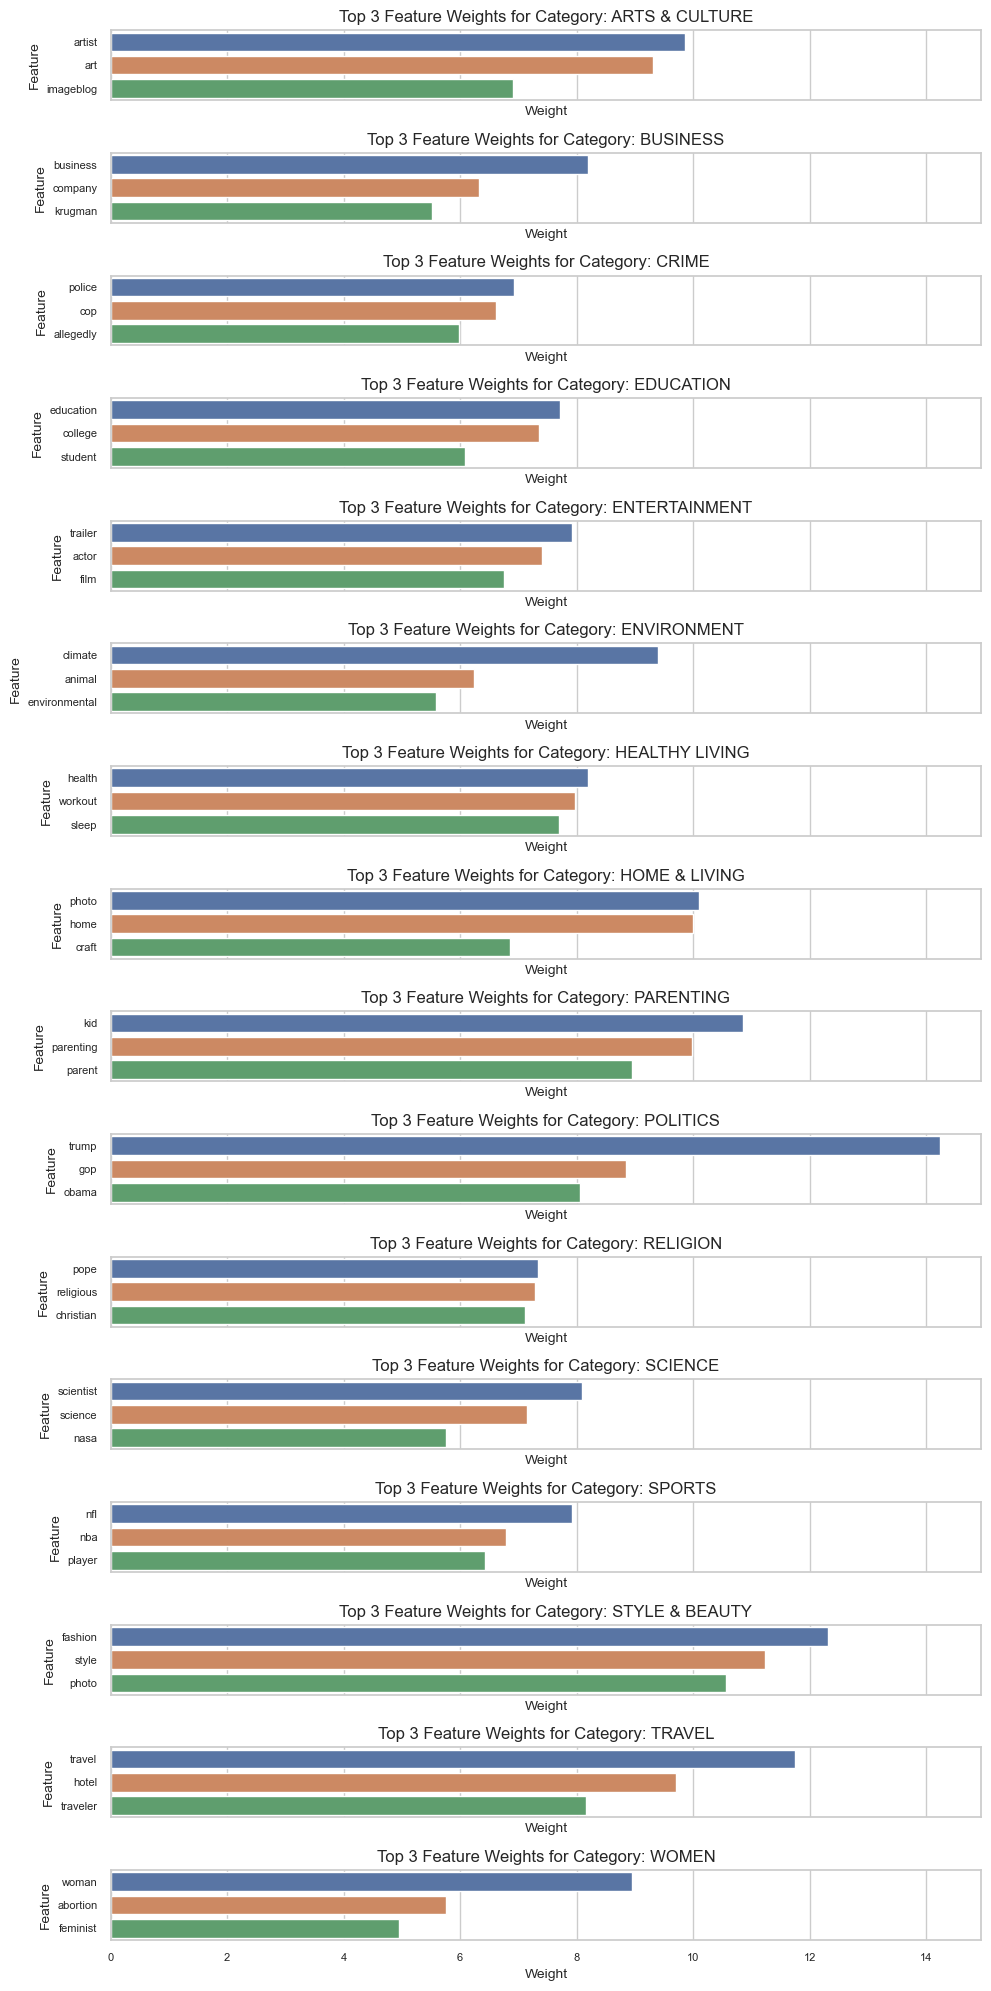

In [71]:
# Plot the top 3 features per category
sns.set(style="whitegrid", font_scale=0.8)

fig, axes = plt.subplots(len(class_names), 1, figsize=(10, 20), sharex=True)


for i, category in enumerate(class_names):
    # Filter the DataFrame for the current category
    category_df = top_weights_df[top_weights_df['Category'] == category]
    
    
    sns.barplot(data=category_df, x='Weight', y='Feature', ax=axes[i])
    axes[i].set_title(f'Top 3 Feature Weights for Category: {category}', fontsize=12)  # Adjust title font size
    axes[i].set_xlabel('Weight', fontsize=10)  # Adjust x-label font size
    axes[i].set_ylabel('Feature', fontsize=10)  # Adjust y-label font size
    axes[i].tick_params(axis='both', labelsize=8)  # Adjust tick label font size

plt.tight_layout()

plt.show()

Future Steps and Recommendations.
Resource limitations constrained further exploration of new models. Therefore, the subsequent step in this study involves an investigation into the SVC model, initially omitted due to its prolonged execution time.

Future exploration will also focus on understanding the low precision observed in some categories, such as 'Woman.' One approach is to reduce the dataset to 25% of its size and perform Gridsearch with different model options. This smaller dataset will enable quicker experimentation. After identifying promising models and hyperparameters, the study can be scaled up to the full dataset to confirm the model selection.

Additionally, the study aims to address specific challenges, such as improving precision for categories with historically lower performance. This iterative process will involve refining feature engineering, fine-tuning models, and exploring alternative text representation techniques.

In addition to these steps, the study will consider the following technical modeling strategies:

Model Stacking: Implement model stacking or blending, where predictions from multiple models are combined using another machine learning algorithm. This ensemble approach can often lead to enhanced model performance.

Transfer Learning: Investigate transfer learning from pre-trained models on large text corpora. Fine-tuning these models for your specific classification task can leverage pre-learned knowledge and potentially improve accuracy.

Advanced NLP Models: Investigate more advanced natural language processing (NLP) models, such as Transformer-based models (e.g., BERT, GPT-3) or sequence-to-sequence models (e.g., LSTM, GRU). These models excel in various NLP tasks and may capture intricate relationships in the data.

Finally, the ultimate goal is to build a robust and accurate model for the News_Category_Dataset, leveraging the insights gained from this initial analysis. Achieving a 76% accuracy rate represents a promising starting point, given the dataset's complexity and initial model performance.
